# Comparisons of different optimizeers for QAOA (Portfolio Optimization)
In this notebook different optimizers for the QAOA parameters are compared, for the problem of portfolio optimization. Both the values of the parameters and the resulting approximation ratio are compared. We try each optimizer for both the penalty method and the XY-mixer method of incorporating the fixed budget constraint. 
# Importing necessary modules


In [1]:
#run: pip install openquantumcomputing
from openquantumcomputing.QAOAPortfolioOptimization import QAOAPortfolioOptimization
from openquantumcomputing.QAOAPortfolioOptimization_mixer import QAOAPortfolioOptimization_mixer
from asset_loader import AssetData
from utilities_portOpt import computeMinMaxCosts, computeAverageApproxRatio, approxRatio
from qiskit import *
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from qiskit_algorithms.optimizers import SPSA, QNSPSA, COBYLA, NELDER_MEAD

# Creating problem instance

c:\Users\olaib\QuantumComputing\optimization\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


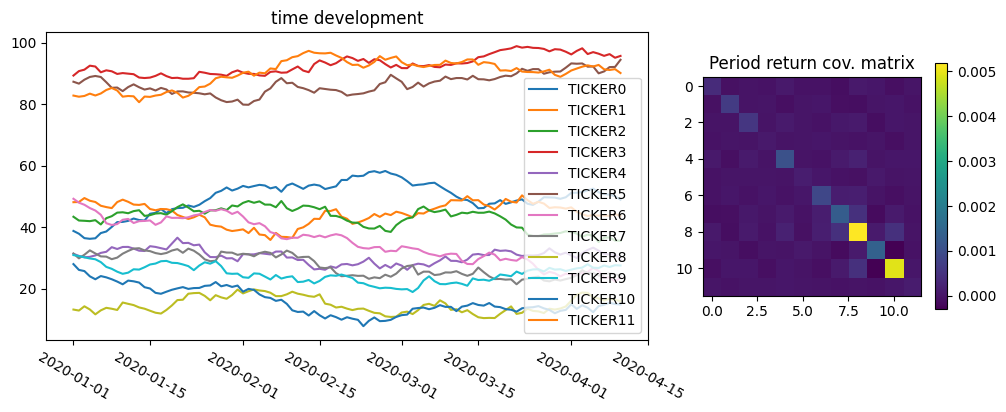

In [2]:
number_of_assets = 12
budget = 6

filename = os.path.join("data", "qiskit_finance_seeds.npz")
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()

# Setting up the optimizers to use roughly the same number of function evaluations

In [3]:
optimizers={}
plotstyle={}

settings = {
    "maxiter": 70,
    "blocking": True,
    "allowed_increase": 0,
    "second_order": True,
    "regularization": 0.01
}
optimizers["spsa"] = [SPSA, settings.copy()]
plotstyle["spsa"] = '+-'

settings = {
    "maxiter": 50,
    "blocking": True,
    "allowed_increase": 0,
    "learning_rate": 0.02,
    "perturbation": 0.05,
    "regularization": 0.01,
    "hessian_delay": 0
}
optimizers["qnspsa"] = [QNSPSA, settings.copy()]
plotstyle["qnspsa"] = 'o-'

settings = {
    "maxiter": 110,
    "tol": 1e-6 
}
optimizers["neldermead"] = [NELDER_MEAD, settings.copy()]
plotstyle["neldermead"] = 'x-'

settings = {
    "maxiter": 350,
    "tol": 1e-6 
}
optimizers["cobyla"] = [COBYLA, settings.copy()]
plotstyle["cobyla"] = '*-'

# Creating QAOA instances (both penalty and XY-mixer method) for each optimizer

In [4]:
gamma_scale = 5000 #Adjusts the search range for the gamma parameter 

#See Sebastian Brandhofer et al. “Benchmarking the performance of portfolio optimization with QAOA”. In:
#Quantum Information Processing 22.1 (2023), page 25-26)
#or Zichang He et al. #Alignment between Initial State and Mixer Improves QAOA Performance for 
#Constrained Portfolio Optimization page 7 (2023)


params_penalty = {
    "risk" : 0.5*gamma_scale,
    "budget": budget,
    "penalty": 4*gamma_scale, #Use optimal penalty?????
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return*gamma_scale,
    "usebarrier": False #OBS: only set to true for drawing NOT for simulations
}

params_XYmixer = {
    "risk" : 0.5*gamma_scale,
    "budget": budget,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return*gamma_scale,
    "usebarrier": False #OBS: only set to true for drawing NOT for simulations
}


qaoa_penalty = {}
qaoa_XYmixer = {}
for key in optimizers:
    params_penalty["optimizer"] = optimizers[key]
    qaoa_penalty[key] = QAOAPortfolioOptimization(params = params_penalty)
    if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
        params_XYmixer["optimizer"] = optimizers[key]
        qaoa_XYmixer[key] = QAOAPortfolioOptimization_mixer(params = params_XYmixer)

# Sample cost landscape for each QAOA instance

In [5]:
for key in optimizers:
    qaoa_penalty[key].sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})
    if key != "qnspsa": # QNSPSA does not work for the XY-method???
        qaoa_XYmixer[key].sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,2*np.pi,10]})

Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Its now computing the feasible subspace
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Its now computing the feasible subspace
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating Energy landscape done
Calculating Energy landscape for depth p=1...
Executing sample_cost_landscape
parameters:  2
Done execute
Done measurement
Calculating 

# Plot the cost landscape for the penalty method, for one optimizer

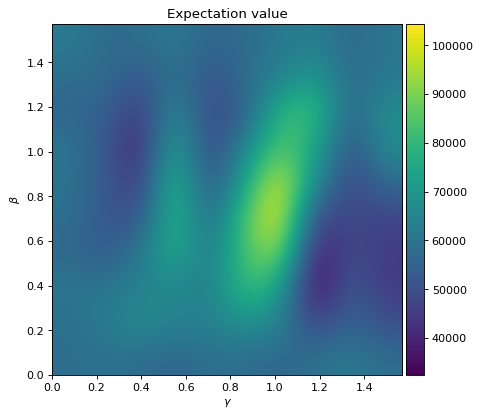

In [6]:
method = "cobyla"

f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoa_penalty[method].E,interpolation='bicubic',origin='lower',extent=[0,np.pi/2,0,np.pi/2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)

# Plot the cost landscape for the XY-mixer method, for one optimizer

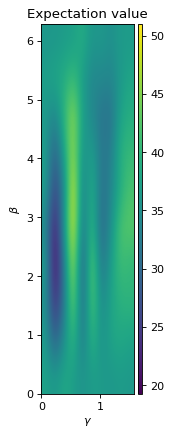

In [7]:
method = "cobyla"

f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoa_XYmixer[method].E,interpolation='bicubic',origin='lower',extent=[0,np.pi/2,0,2*np.pi])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)
#Note that the beta range is different for for the penalty method and the XY-mixer method, due to 
#different periods in the mixers.

# Increasing depth for all QAOA instances

In [8]:
maxdepth=10
for i in range(maxdepth):
    for key in optimizers:
        qaoa_penalty[key].increase_depth()
        if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
            qaoa_XYmixer[key].increase_depth()

cost(depth= 1 )= 33070.811237424496
cost(depth= 1 )= 20.2321120665426
cost(depth= 1 )= 36410.70726832774
cost(depth= 1 )= 28481.421209843495
cost(depth= 1 )= 3.2310537674209296
cost(depth= 1 )= 29868.65079792973
cost(depth= 1 )= 5.449193762482691
cost(depth= 2 )= 46539.770172396886
cost(depth= 2 )= 2.770466298427799
cost(depth= 2 )= 54660.0788176827
cost(depth= 2 )= 26653.7857936592
cost(depth= 2 )= 7.070666485108993
cost(depth= 2 )= 32000.198691415946
cost(depth= 2 )= 1.0750880452762046
cost(depth= 3 )= 38019.51561465705
cost(depth= 3 )= 0.8854352580647699
cost(depth= 3 )= 60799.56017028817
cost(depth= 3 )= 22618.67446759236
cost(depth= 3 )= -4.284241166296235
cost(depth= 3 )= 31875.73134712232
cost(depth= 3 )= 3.8829194118047967
cost(depth= 4 )= 39367.438099846506
cost(depth= 4 )= 0.1694858187136332
cost(depth= 4 )= 60955.73160245643
cost(depth= 4 )= 34335.276213400386
cost(depth= 4 )= -5.119152055908779
cost(depth= 4 )= 33008.178685320985
cost(depth= 4 )= 3.6982971319361693
cost(dep

# Compute and print the optimal solution with minium cost

In [9]:
method = "cobyla"
cost_func = qaoa_penalty[method].cost 
isFeasible_func = qaoa_penalty[method].isFeasible 
#These function are the same for all methoods

min_cost, max_cost, solution = computeMinMaxCosts(number_of_assets, cost_func, isFeasible_func)
print("Optimal solution: ", solution, "\n With cost: ", min_cost)

Optimal solution:  100100101011 
 With cost:  -29.063041157787666


In [10]:
hists_penalty = {}
hists_XYmixer = {}


for key in optimizers:
    hists_penalty[key] = [qaoa_penalty[key].hist(qaoa_penalty[key].angles_hist['d'+str(1)+'_final'])]
    if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
        hists_XYmixer[key] = [qaoa_XYmixer[key].hist(qaoa_XYmixer[key].angles_hist['d'+str(1)+'_final'])]
    for i in range(1, maxdepth):
            hists_penalty[key].append(qaoa_penalty[key].hist(qaoa_penalty[key].angles_hist['d'+str(i+1)+'_final']))
            if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
                hists_XYmixer[key].append(qaoa_XYmixer[key].hist(qaoa_XYmixer[key].angles_hist['d'+str(i+1)+'_final']))



apprx_ratio_penalty = {} #List of approx ratios for different depths at each key in this dictionary
apprx_ratio_XYmixer = {} #List of approx ratios for different depths at each key in this dictionary

for key in optimizers: 
    apprx_ratio_penalty[key] = [computeAverageApproxRatio(hists_penalty[key][0], max_cost, min_cost, cost_func, isFeasible_func)]
    if key != "qnspsa":
        apprx_ratio_XYmixer[key] = [computeAverageApproxRatio(hists_penalty[key][0], max_cost, min_cost, cost_func, isFeasible_func)]   
    for i in range(1, maxdepth):
        apprx_ratio_penalty[key].append(computeAverageApproxRatio(hists_penalty[key][i], max_cost, min_cost, cost_func, isFeasible_func))
        if key != "qnspsa":
            apprx_ratio_XYmixer[key].append(computeAverageApproxRatio(hists_XYmixer[key][i], max_cost, min_cost, cost_func, isFeasible_func))


apprx_ratio_penalty2 = {}
apprx_ratio_XYmixer2 = {}
for key in optimizers:
    apprx_ratio_penalty2[key] = approxRatio(list(qaoa_penalty[key].costval.values()), max_cost, min_cost)
    if key != "qnspsa":
        apprx_ratio_XYmixer2[key] = approxRatio(list(qaoa_XYmixer[key].costval.values()), max_cost, min_cost)


# Plotting the approximation ratios using the penalty method the different optimizers

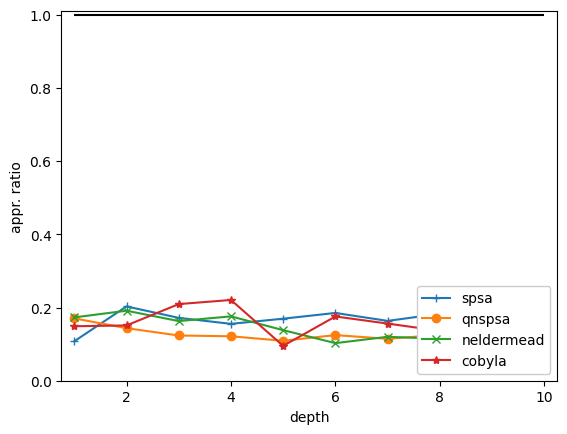

In [11]:
ax = pl.figure().gca()
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
for key in optimizers:
    pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty[key], plotstyle[key], label=key)
pl.ylim(0,1.01)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend(loc="lower right", framealpha=1)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the approximation ratios using the penalty method the different optimizers (SECOND WAY)

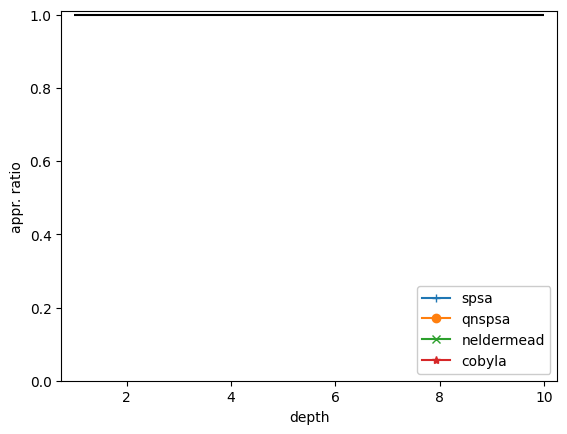

In [12]:
ax = pl.figure().gca()
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
for key in optimizers:
    pl.plot(np.arange(1,maxdepth+1), apprx_ratio_penalty2[key], plotstyle[key], label=key)
pl.ylim(0,1.01)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend(loc="lower right", framealpha=1)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the approximation ratios using the XY-mixer method for the different optimizers

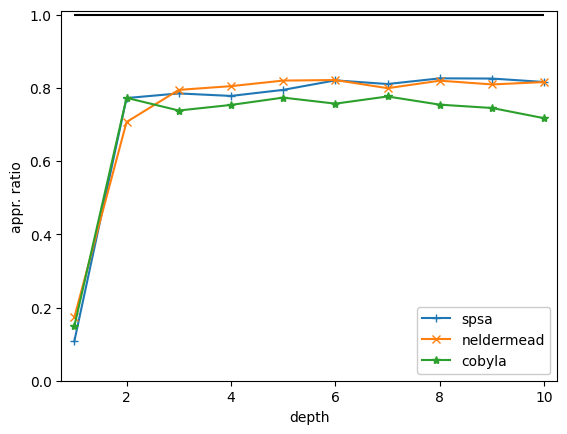

In [13]:
ax = pl.figure().gca()
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
for key in optimizers:
    if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
        pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer[key], plotstyle[key], label=key)
pl.ylim(0,1.01)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend(loc="lower right", framealpha=1)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the approximation ratios using the XY-mixer method for the different optimizers (SECOND WAY)

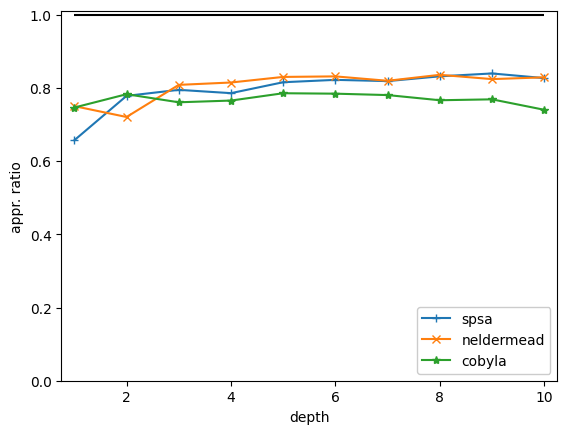

In [14]:
ax = pl.figure().gca()
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
for key in optimizers:
    if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
        pl.plot(np.arange(1,maxdepth+1), apprx_ratio_XYmixer2[key], plotstyle[key], label=key)
pl.ylim(0,1.01)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend(loc="lower right", framealpha=1)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the values for the parameters for the penalty method

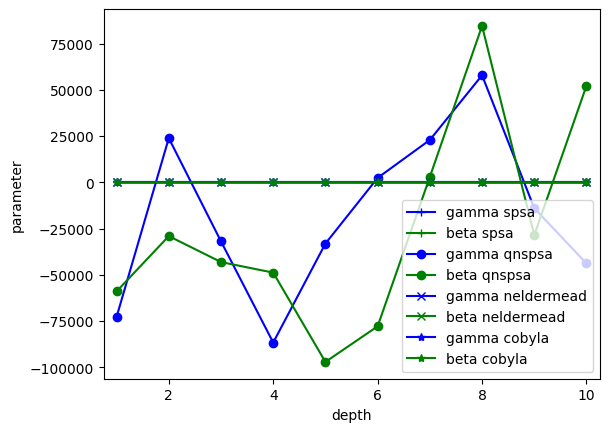

In [15]:
ax = pl.figure().gca()
for key in optimizers:
    pl.plot(np.arange(1,maxdepth+1),qaoa_penalty[key].angles_hist['d'+str(maxdepth)+'_final'][::2],"b"+plotstyle[key],label='gamma '+key)
    pl.plot(np.arange(1,maxdepth+1),qaoa_penalty[key].angles_hist['d'+str(maxdepth)+'_final'][1::2],"g"+plotstyle[key],label='beta '+key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('parameter')
_=pl.xlabel('depth')
_=pl.legend()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the values for the parameters for the XY-mixer method

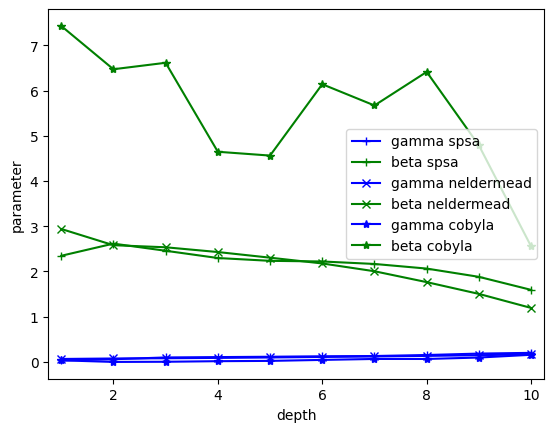

In [16]:
ax = pl.figure().gca()
for key in optimizers:
    if key !="qnspsa": #qnspsa does not work for the XY-mixer method???
        pl.plot(np.arange(1,maxdepth+1),qaoa_XYmixer[key].angles_hist['d'+str(maxdepth)+'_final'][::2],"b"+plotstyle[key],label='gamma '+key)
        pl.plot(np.arange(1,maxdepth+1),qaoa_XYmixer[key].angles_hist['d'+str(maxdepth)+'_final'][1::2],"g"+plotstyle[key],label='beta '+key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('parameter')
_=pl.xlabel('depth')
_=pl.legend()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the number of function evaluations used by each optimizer for the penalty method

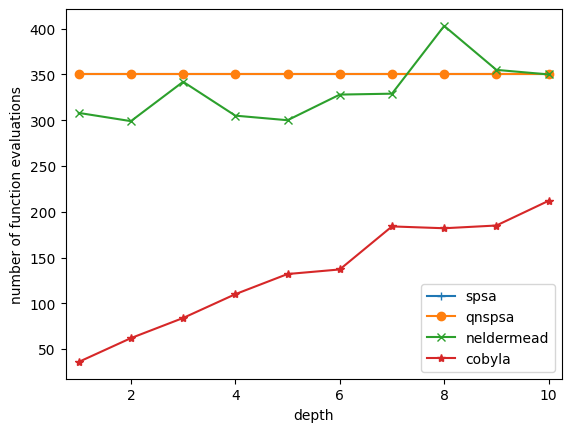

In [17]:
ax = pl.figure().gca()
for key in optimizers:
    _=pl.plot(np.arange(1,maxdepth+1),qaoa_penalty[key].num_fval.values(), plotstyle[key], label=key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('number of function evaluations')
_=pl.xlabel('depth')
_=pl.legend()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the numver of function evaluations used by each optimizer

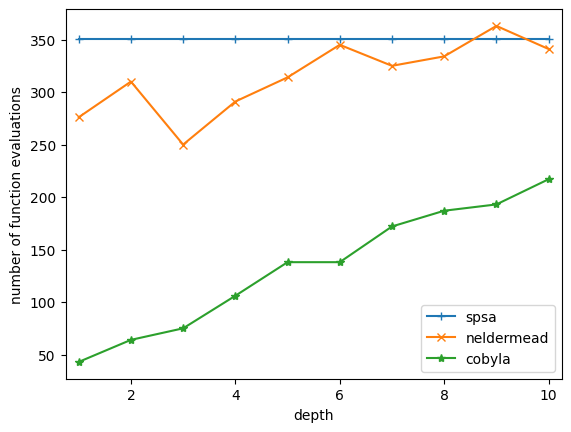

In [18]:
ax = pl.figure().gca()
for key in optimizers:
    if key != "qnspsa": #qnspsa does not work for the XY-mixer method???
        _=pl.plot(np.arange(1,maxdepth+1),qaoa_XYmixer[key].num_fval.values(), plotstyle[key], label=key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('number of function evaluations')
_=pl.xlabel('depth')
_=pl.legend()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Should a test be done with CVaR and different optimizers?